In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import timm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class BestModel(nn.Module):
    def __init__(self, num_classes=5):  # Assuming 5 classes for classification
        super(BestModel, self).__init__()
        self.densenet = timm.create_model('densenet121', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.densenet(x)

# Load the trained DenseNet model
model = BestModel()
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

BestModel(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): DenseBlock(
        (denselayer1): DenseLayer(
          (norm1): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNormAct2d(
            128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv2): Conv2d(128, 32, kern

In [3]:
# Transformation for input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

C:\Users\VSA\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


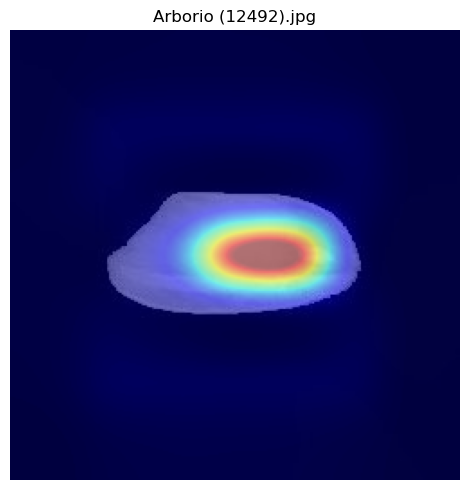

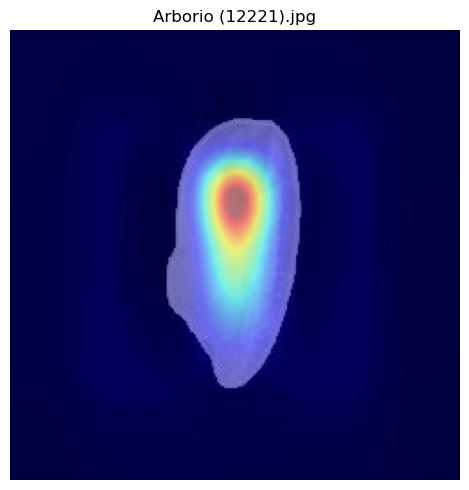

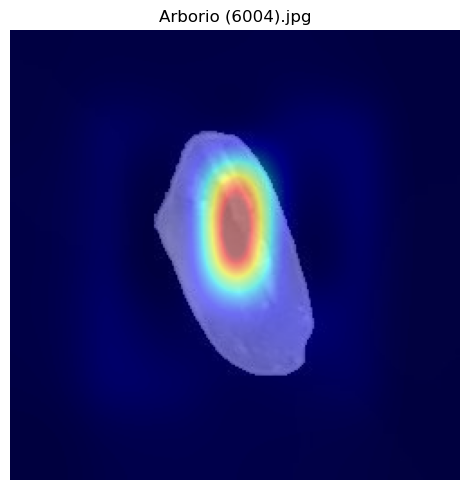

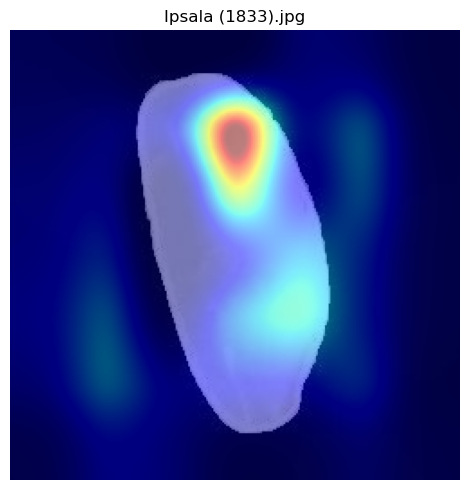

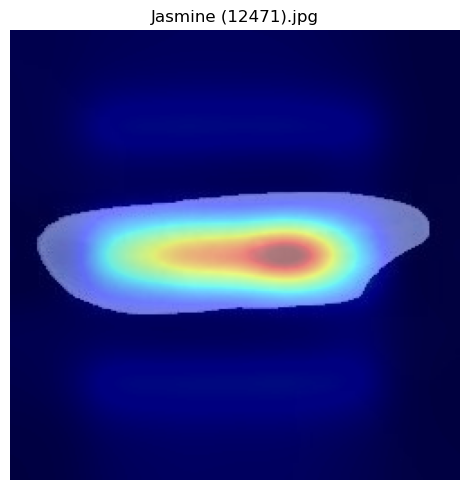

In [4]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
for i in range (5):
    # 클래스와 이미지 번호 무작위 선택
    label = random.choice(['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'])
    number=random.randint(1,15000)
    # 이미지 읽어오기
    img = read_image("./Rice_Image_Dataset/"+label+"/"+label+" ("+str(number)+").jpg")
    # 이미지 변환(resize 및 정규화)
    input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # SmoothGrad CAM 적용
    with SmoothGradCAMpp(model) as cam_extractor:
        # 전처리한 데이터 모델에 입력
        out = model(input_tensor.unsqueeze(0))
        # Class Index와 모델 출력을 사용하여 CAM 추출
        activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
        # CAM 오버레이
        result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
        # 결과 출력
        plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.title(label+" ("+str(number)+").jpg"); plt.show()